# Faster R-CNN Implementations by Pytorch

**Reference** : [How FasterRCNN works and step-by-step PyTorch implementation](https://youtu.be/4yOcsWg-7g8)

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [118]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [119]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print(DEVICE)

cuda Tesla T4


## Data Preprocessing

### 1) Visualize image and bounding boxes

(1333, 2000, 3)


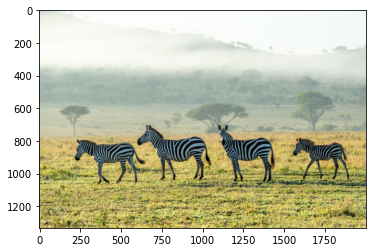

In [120]:
# In this example, only use 1 image, i.e, batch_size=1
# input image could be of any size

img0 = cv2.imread("/content/drive/MyDrive/zebras.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [121]:
# object information : a set of bounding boxes [x1, y1, x2, y2] 
# and their labels
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 
labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

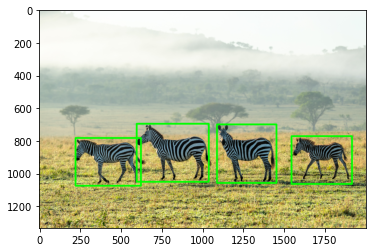

In [122]:
# display bounding box and labels

img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), 
                              (bbox0[i][2], bbox0[i][3]),
                 color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

### 2) Resize image and bounding boxes

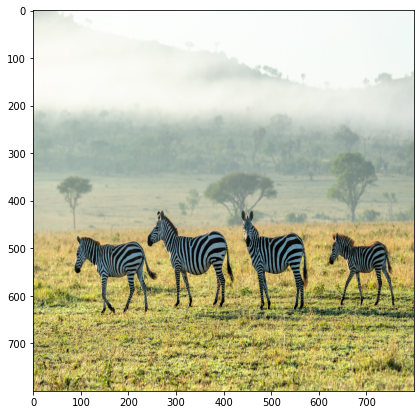

In [123]:
# resize the input images to h=800, w=800 
#편의를 위해 800 x 800 크기로 resize 실제 sub-sampling ratio =1/16으로 지정하여 feature extractor를 거친 features map의 크기는 50x50이 됩니다.

img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
# plt.grid(True, color="black")
plt.show()

0.4 0.6001500375093773
[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


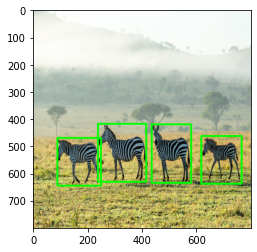

In [124]:
# change the bounding box coordinates
# original image size : (1333, 2000)

Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

## Define Feature extractor

### 1) Load pretrained VGG16

In [125]:
# only print feature extraction part of VGG16

model = torchvision.models.vgg16(pretrained=True).to(DEVICE) #모델 정의
features = list(model.features)
print(len(features))
print(features)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

### 2) Only collect required layers

In [126]:
# only collect layers with output feature map size (W, H) < 50

dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(DEVICE)

for feature in features:
    output = feature(output)
#     print(output.size()) => torch.Size([batch_size, channel, width, height])
    if output.size()[2] < 800//16: # 800/16=50, 800*800에서 생성된 50*50의 feature map이므로 subsampling ratio=16으로.
        break
    req_features.append(feature)
    out_channels = output.size()[1]
    
print(len(req_features))
# print(req_features)
print(out_channels)

#800*800*3 input image로 VGG-16을 거쳐서 50*50*512의 Feature map이 생성 ZFNet 기준으로 256-d, VGG-16은 512-d

torch.Size([1, 3, 800, 800])
30
512


In [127]:
# convert this list into a Seqeuntial module

faster_rcnn_feature_extractor = nn.Sequential(*req_features)# 변수에 전체 모델에서 해당 layer까지 저장

In [128]:
faster_rcnn_feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [129]:
# test the results of the input image pass through the feature extractor
# 원본이미지를 faster_rcnn_feature_extractor에 입력하여 50*50*512크기의 features map을 얻습니다.

transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(DEVICE)
imgTensor = imgTensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(imgTensor)

print(imgTensor.size())
print(output_map.size())

torch.Size([1, 3, 800, 800])
torch.Size([1, 512, 50, 50])


imgTensor.size()m

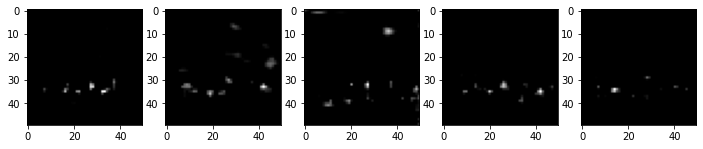

In [130]:
# visualize the first 5 channels of the 50*50*512 feature maps

imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

## Generate Anchors Boxes

### 1) Generate Anchors

In [131]:
#Anchor generation layer
#Anchor generation layer에서는 anchor box를 생성하는 역할을 합니다.
# sub-sampling rate = 1/16
# image size : 800x800
# sub-sampled feature map size : 800 x 1/16 = 50
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
# total anchor boxes = 50 x 50 x 9 = 22500
# x,y intervals to generate anchor box center
#22500개의 anchor boxes를 생성하기 위해 16*16 간격의 grid마다 anchor를 생성

feature_size = 800 // 16
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [132]:
# coordinates of the 255 center points to generate anchor boxes

index = 0
ctr = np.zeros((2500, 2))

for i in range(len(ctr_x)):
    for j in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[i] - 8
        ctr[index, 0] = ctr_y[j] - 8
        index += 1

# ctr => [[center x, center y], ...]
print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


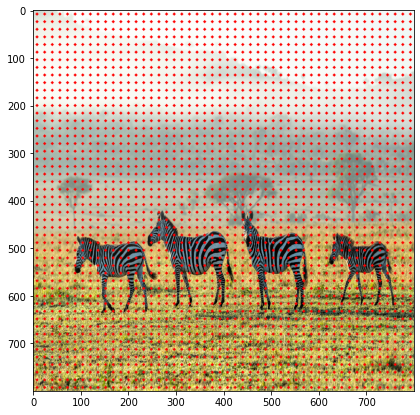

In [133]:
# display the 2500 anchors within image

img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

### 2) Generate Anchor boxes

In [134]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500 x 9 = 22500 anchor boxes
# anchor를 기준으로 서로 다른 scale과 aspect ratio를 가지는 9개의 anchor box를 생성해줍니다.
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4)) #50*50*9,4 = (22500,4)
index = 0

for c in ctr:                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i]) # 16 * scale * ratios -> 왜 제곱근?
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            
            # anchor box [x1, y1, x2, y2] 좌표 저장
            anchor_boxes[index, 1] = ctr_y - h / 2. 
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


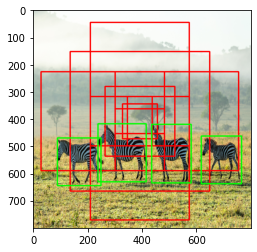

In [135]:
# display the anchor boxes of one anchor and the ground truth boxes

img_clone = np.copy(img)

# draw random anchor boxes
for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), 
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

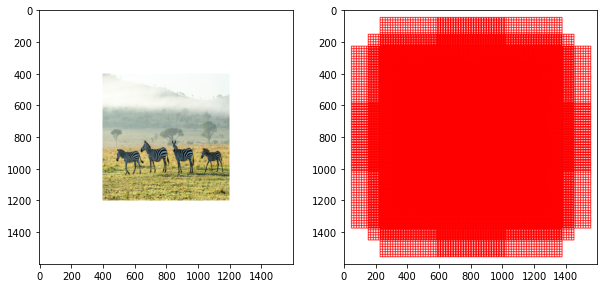

In [136]:
# draw all anchor boxes

# add paddings(can't draw anchor boxes out of image boundary)
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

## Target Anchors

### 1) Only choose anchor boxes inside the image

In [137]:
# Anchor Target layer에서는 RPN을 학습시키기 위해 적절한 anchor box를 선택하는 작업을 수행합니다
# ignore the cross-boundary anchor boxes
# valid anchor boxes with (x1, y1) > 0 and (x2, y2) <= 800
# 

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

# only 8940 anchor boxes are inside the boundary out of 22500
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)
#800*800 내부에 있는 anchor box만을 선택 8940개

(8940,)
(8940, 4)


### 2) Calculate IoUs

In [138]:
valid_anchor_boxes

array([[ 10.745166  ,  13.49033201, 101.254834  , 194.50966799],
       [ 10.745166  ,  29.49033201, 101.254834  , 210.50966799],
       [ 10.745166  ,  45.49033201, 101.254834  , 226.50966799],
       ...,
       [698.745166  , 573.49033201, 789.254834  , 754.50966799],
       [698.745166  , 589.49033201, 789.254834  , 770.50966799],
       [698.745166  , 605.49033201, 789.254834  , 786.50966799]])

In [139]:
# 전체 anchor box에 대하여 ground truth box와의 IoU값을 구함.
# calculate Iou of the valid anchor boxes
# since we have 8940 anchor boxes and 4 ground truth objects,
# we should get an array with (8940, 4) as the output
# [IoU with gt box1, IoU with gt box2, IoU with gt box3,IoU with gt box4]

ious = np.empty((len(valid_anchor_boxes),4), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bbox):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1) #IoU = 교집합/합집합
            iou = inter_area / (anchor_area + box_area - inter_area) 
        else:
            iou = 0
        
        ious[i, j] = iou 
        
print(ious.shape)
print(ious[7500:7550, :])

(8940, 4)
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.02401448 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.05704415 0.0255757 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.04309982 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.07024091 0.0392861 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.02380745 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.06291009 0.01228882]
 [0.         0.         0.00830436 0.        ]
 [0.         0.         0.08377136 0.05336803]
 [0.         0.         0.         0.        ]
 [0.         0.         0.04958539 0.        ]
 [0.         0.         0.00464733 0.        ]
 [0

### 3) Sample positive/negative anchor boxes

In [140]:
# what anchor box has max iou with the ground truth box
# 어떤 anchor box가 최대치인지
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[1008 2862 5935 8699]
[0.58514285 0.5752716  0.5255493  0.6325869 ]
[1008 1013 1018 1226 1232 1238 2862 2869 2876 3108 3115 3122 3336 3343
 3350 3354 3357 3361 3364 3368 3371 3377 3383 3389 3600 3607 3614 3846
 3853 3860 5935 5942 6164 6171 6178 6181 6185 6188 6192 6198 6427 6434
 8699 8703 8707]


In [141]:
# what ground truth bbox is associated with each anchor box
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 3 3 3]
[0.         0.         0.         ... 0.11051063 0.08043041 0.05193678]


In [142]:
# set the labels of 8940 valid anchor boxes to -1(ignore)

label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [143]:
# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box # ground truth box와 IoU가 가장 큰 anchor box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box # IoU값이 0.7이상인 anchor box를 postive sample로

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3 #IoU값이 0.3 미만인 anchor box는 negative sample로 저장.

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [144]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 
n_sample = 256 #미니배치 256
pos_ratio = 0.5 #postive sample에 해당하는 비율1:1
n_pos = pos_ratio * n_sample 

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos: # postive sample의 수가 128개 이상인 경우 남는 postive sample에 해당하는 sample은 label 변수에 -1로 지정합니다.
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample - np.sum(label == 1) #?? 왜..? 이게 원래 n_sample * np.sum(label ==1)이였음
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [145]:
# convert the format of valid anchor boxes [x1, y1, x2, y2]

# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [146]:
# First set the label=-1 and locations=0 of the 22500 anchor boxes, 
# and then fill in the locations and labels of the 8940 valid anchor boxes
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1) #-1로 채우기
anchor_labels[index_inside] = label #valid anchor boxes 8940 채움
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0) #0으로 채움
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## RPN(Region Proposal Network)

### 1) Define RPN

In [147]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)
# 생성된 feature map에 3*3 conv연산을 적용하는 layer를 정의. 이후 1*1 연산을 적용하여 9*4(anchor box의 수 * bounding box coordinates)개의 channel을 가지는 feature map을 반환하는 Bounding box regressor를 정의합니다.
# 마찬가지로 1*1 conv연산을 적용하여 9*2(anchor box의 수 * object여부)개의 chaanel을 가지는 feature map을 반환하는 Classifier를 정의합니다.

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(DEVICE) #50*50*512크기의 Feature Map을 Conv layer를 한번 거치고
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(DEVICE) # 1*1 conv인 bbox Regression Layer(50*50*512 -> 50*50*36)와 박스*좌표
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not) 
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(DEVICE)# 50*50*512 -> 50*50*18을 통해 바운딩 박스의 위치와 클래스 예측을 완료합니다.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()



tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

### 2) Classification and Bounding box regression

In [148]:
#앞서 얻은 50*50*512 크기의 feature map을 3*3 conv layer에 입력합니다. 이를 통해 50*50*512크기의 feature map을 Bounding box regressor, Classifier에 입력하여 각각 bounding box coefficients와 objectness score를 얻습니다.
#이를 targer값과 비교하기 위해 아래 과정에서 resize해줍니다.
x = conv1(output_map.to(DEVICE)) # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output 
pred_cls_scores = cls_layer(x)  # classifier output 

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [149]:
# Convert RPN to predict the position and classification format of the anchor box
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw)  
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)
#Target값과 비교하기 위해 적절히 resize 진행
# bouniding box 좌표(4개)이므로 OUTPUT은 Anchor 총 수와 맞춰서  50*50*9*4=(22500,4), 50*50*9*2=(22500,2)
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [150]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [151]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


### 3) Multi-task loss

In [152]:
# For classification we use cross-entropy loss
# prediction한 값과 앞서 구했던 이미지의 Ground Truth Label과 함께 Loss Function을 통해 RPN을 학습 이후 예측된 두 값은 NMS를 거쳐서 특정 개수의 RoI로 sampling된 후 Fast-RCNN에 쓰이게된다.
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(DEVICE), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward0>)


In [153]:
# only positive samples
#Bounding box regrssion loss는 오직 positive에 해당하는 sample에 대해서만 loss를 계산하므로, positive/negative 여부를 저장하는 배열인 mask를 생성합니다.
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4) #예측값 
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)# 타겟값 
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5)) #smooth l1 loss?
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([45, 4]) torch.Size([45, 4])
tensor(16.2298, dtype=torch.float64, grad_fn=<SumBackward0>)


In [154]:
# Combining both the rpn_cls_loss and rpn_reg_loss
# balancing parameter을 람다 10으로 지정해주고 loss를 더해 multi-task loss를 구합니다.
rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(4.2976, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


## Proposal layer

### 1) Transform anchor boxes

In [155]:

# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000
# Anchor generation layer에서 생성된 anchor boxes와 RPN에서 반환한 class scores와 bounding box regressor를 사용하여 region proposals를 추출하는 작업을 수행

nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS Objectness score 상위 N(n_train _pre_nms=12000)개의 anchor box에 대하여 Non Maximum suppression알고리즘 수행.
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals 남은 anchor box 중 상위 N(n_train_pos_nms=2000)개의 region proposals를 학습에 사용
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [156]:
# the labelled 22500 anchor boxes 
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [157]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [158]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [159]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


### 2) Clip the anchor boxes to the image

In [160]:
# clip the predcited boxes to the image 800 clip

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [161]:
# remove predicted boxes with either height or width < threshold

hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500,) (22500, 4) (22500,)


### 3) Select top-12000 anchor boxes by objectness score

In [162]:
# sort all (proposal, score) pairs by score from highest to lowest 
# Fast R-CNN에서 RoI로 작용하는데 Prediction된 Box들에 NMS를 거치고 RoI sampling을 통해 최종 RoI를 결정
# NMS는 주로 중복되는 Bounding Box를 제거하기 위해 쓰입니다. 많은 수의 Anchor Box끼리 겹치는 부분이 많기 때문에 한 물체에 여러개의 Bounding box가 생기게된다.
# RPN에서 앞서 예측한 box들 중 RoI score로 정렬
order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [163]:
# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]#12000
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


### 4) Non maximum suppression(select 2000 bounding boxes)

In [164]:

# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [165]:
x1.shape

(12000,)

In [166]:
areas.shape

(12000,)

In [167]:
# take the indexes of order the probability score in descending order 내림차순
# non maximum suppression 알고리즘
#높은 RoI Score를 가진 box와 overlapping된 다른 box들을 지워 나가는 식으로 반복하여 Box Overlapping이 일어나지 않으면서 RoI가 높은 Box들만 남도록 하는 방식입니다.
#Overlapping에 대한 Threshold는 주로 0.6에서 0.9정도를 사용합니다.


order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0] #overlapping에 대한 threshold 0.7
  order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly 보통 training시 NMS를 거치면 2000개의 RoI가 남습니다.
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


## Proposal Target layer

### 1) Calculate IoUs

In [168]:
#2000개의 RoI중에서 positive : negative 비율이 1:!이 되도록 RoI를 Sampling합니다. 256개를 sampling한다고 치면 128개의 positive anchor, 128개의 negative anchor이 sampling 됩니다.
#만약 positive인 anchor이 128개가 안되면 Zero Padding을 하거나 IoU값이 가장 높은 box를 positive로 사용합니다.

n_sample = 128 # number of samples from roi 학습을 위해 128개의 샘플을 mini-batch로 구성. 
pos_ratio = 0.25 # number of positive examples out of the n_samples
#이때 proposal layer에서 얻은 anchor box 중 ground truth box와의 IoU값이 0.5 이상인 box를 positive sample로 0.5미만인 box를 negative sample로 지정합니다 
# 전체 미니배치 샘플(128개)중 1/4(32)개가 positive sample이 되도록 구성. positive sample이 32개 미만인 경우 부족한 sample은 negative sample에서 구합니다 
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [169]:
# fine the iou of each ground truth object with the region proposals

ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

(2000, 4)


In [170]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[3 0 0 ... 0 0 0]
[0.03320927 0.         0.         ... 0.         0.         0.        ]
[1 1 1 ... 1 1 1]


In [171]:
gt_roi_label

array([1, 1, 1, ..., 1, 1, 1])

### 2) Select foreground(positive) samples

In [172]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0] #max iou가 0.5보다 큰것
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size)) #28

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

22
[1794 1113 1181  269  323 1065  920  931  933  928  500  445  379 1186
  994  160   36 1800  872  381 1062   30]


### 3) Select background(negative) samples

In [173]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

106
[1828 1584  475  679  839 1419 1066 1195 1072  746   60 1614  766 1207
  887  369 1025   55 1471 1963  997 1396  964  906 1159  616 1830 1366
 1132 1323  993  674 1350  724  422 1650 1271 1532 1414 1718  833 1117
 1184   87  319 1825  999  830 1061 1936  979 1475  573 1284  156  293
  417 1395 1180  641   62 1374  698 1789  638 1701 1322 1896 1314  346
  715   13 1537  627 1793  894  658 1327  889  628  525  636  175 1570
 1079 1949 1815  528  922   88    8 1172 1262 1418   50  492  910 1697
 1441  762  820  461 1268 1224 1080   58]


### 4) Visualization

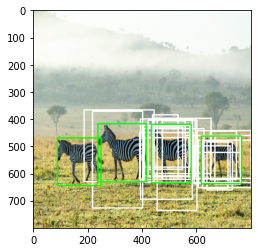

In [174]:
# display RoI samples with positive
# 초록색 box는 ground truth box, 흰색 box는 predicted bounding box.
# 얼룩말 잘잡았죠?~
img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

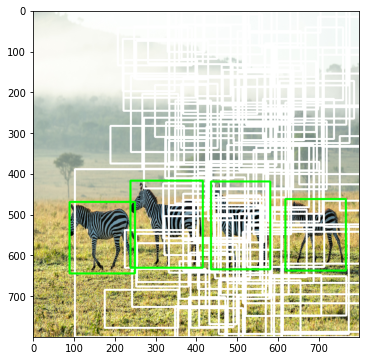

In [175]:
# display RoI samples with negative
# 반면에 다수의 box가 배경을 포함하고 있는 모습 확인
img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

### 5) Gather positive/negative samples

In [176]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [177]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to 
# anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [178]:
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height 

In [179]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


## RoI pooling

### 1) Concatenate labels with bbox coordinates

In [180]:
# Take out the features of 128 ROI samples and
# use max pooling to adjust to the same size, H=7, W=7 (ROI Pooling) output feature map 크기가 7*7이 되도록 설정
# Feature extractor을 통해 얻은 feature map과 proposal target layer에서 추출한 region proposals을 활용하여 RoI pooling을 수행합니다. 이 때 output feature map 크기가 7*7이 되도록 설정합니다.
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [181]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


### 2) RoI pooling

In [182]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [183]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())

torch.Size([128, 512, 7, 7])


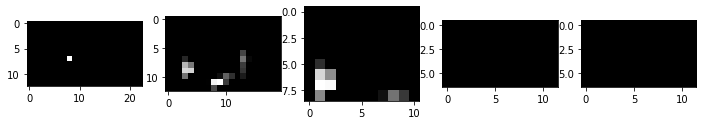

In [184]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [185]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


## Fast R-CNN

### 1) Classifier and Bounding box regressor

In [186]:
# 마지막으로 RoI pooling을 통해 얻은 7*7 크기의 feature map을 입력받을 fc layer을 정의합니다 
# 128 boxes + features (7x7x512) of ROI samples are sent to 
# Detection network to predict the objects bounding box and clas of the input image
# class별로 bounding box coeffcients를 예측하는 bounding box regressor와 class score을 예측하는 classifier을 정의 

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(DEVICE) #첫 fc layer의 크기는 25088(7*7*512)*4096입니다
cls_loc = nn.Linear(4096, 2 * 4).to(DEVICE) # bounding box의 좌표. 1 class, 1 background, 4 coordiinates  #왜 2*4?
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(DEVICE) # 박스안에 물체가 있는지 없는지 class. 1 class, 1 background

In [187]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [188]:
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


### 2) Classification loss

In [189]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


In [190]:
roi_cls_loss

tensor(0.6838, grad_fn=<NllLossBackward0>)

### 3) Regression loss

In [191]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [192]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [193]:
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [194]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([22, 4]) torch.Size([22, 4])
tensor(6.4754, dtype=torch.float64, grad_fn=<SumBackward0>)


### 4) Multi-task loss

In [195]:
roi_lambda = 10.
N_cls=(gt_roi_loc>0).float().sum() #에러나서 직접추가
roi_loc_loss=roi_loc_loss.sum()/N_cls #에러나서 직접 추가
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

total_loss = rpn_loss + roi_loss
print(total_loss)

tensor(0.9167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5.2144, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
